<h3>Double Helix</h3>

<p>
Radius of a small coil <b>(r1)</b><br>
Radius of a large coil <b>(r2)</b><br>
Points per small coil <b>(ptspc)</b> Number of points per small coil. <br>
Number of coils per one large coil <b>(cplc)</b><br>
Number of large coils <b>(nlcoils)</b><br>
Number of poins <b>(npts)</b> Total number of points = <b>ptspc*cplc*nlcoils</b><br>
Step in degrees for a small coil <b>(stepsc)</b><br>
Step in degrees for a large coil <b>(steplc)</b><br>

In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits import mplot3d 
from mpl_toolkits.mplot3d import Axes3D 
from mpl_toolkits.mplot3d.art3d import Text3D
import numpy as np
import math
import time
import pandas as pd
from IPython.display import HTML
%matplotlib notebook

In [15]:
r1 = 1 # Small coil radius
r2 = 5 # large coil radius
ptspc = 20 # number of points per small coil
cplc = 6 # number of coils per large coil
nlcoils = 3 # number of large coils
npts = ptspc*cplc*nlcoils
stepsc = 360/ptspc #step per small coil in degrees
steplc = 360/cplc/ptspc #step per large coil in degrees
ltr_pos = int(ptspc/10) #there should be 10 letters per coil. This is distance in points between two letters
a1 = np.arange(0, npts*stepsc, stepsc) #collection of angles for a small coil
a2 = np.arange(0, 360*nlcoils, steplc) #collection of angles for a large coil
a3 = np.linspace(start=0, stop=2*r1*1.2*nlcoils, num=npts) #z axis elevation
print(f"points per small coil (ptspc) = {ptspc},\ncoils per large coil (cplc) = {cplc}")
print(f"total number of points (ntps) = {npts},\nstep per small coil in degrees (stepsc) = {stepsc}")
print(f"step per large coil in degrees (steplc) = {steplc},\nletter position (ltr_pos) = {ltr_pos} # of points")
print(f"a1 = {a1[:5]},\na2 = {a2[:5]},\na3 = {a3[-5:]}")
print(f"shape of a1 = {a1.shape},\nshape of a2 = {a2.shape}")


points per small coil (ptspc) = 20,
coils per large coil (cplc) = 6
total number of points (ntps) = 360,
step per small coil in degrees (stepsc) = 18.0
step per large coil in degrees (steplc) = 3.0,
letter position (ltr_pos) = 2 # of points
a1 = [ 0. 18. 36. 54. 72.],
a2 = [ 0.  3.  6.  9. 12.],
a3 = [7.11977716 7.13983287 7.15988858 7.17994429 7.2       ]
shape of a1 = (360,),
shape of a2 = (360,)


In [4]:
with open("oca2.txt") as f:
    txt=f.read() # read oca2 gene sequence
txt = txt.replace(' ', '').replace('\n', '')    
# print(txt[:600])
c = pd.Series(list(txt)).map({'g':'c', 'c':'g', 'a':'t', 't':'a'}).tolist() # a complementary sequence mapping
txt2 = ''.join([str(i) for i in c]) # a complementary DNA sequence

In [5]:
#Transalation and rotation matrixes
def createRotationMatrix(angle, axis):
    c=math.cos(math.radians(angle))
    s=math.sin(math.radians(angle))
    if (axis=='x'):
        return np.array(((1,0,0,0),(0,c,s,0),(0,-s,c,0),(0,0,0,1)))
    elif (axis=='y'):
        return np.array(((c,0,-s,0),(0,1,0,0),(s,0,c,0),(0,0,0,1)))
    elif (axis=='z'):
        return np.array(((c,-s,0,0),(s,c,0,0),(0,0,1,0),(0,0,0,1)))
    
def createTranslationMatrix(delta):
    return np.array(((1,0,0,delta[0]), (0,1,0,delta[1]), (0,0,1,delta[2]), (0,0,0,1)))

In [6]:
#Generate coordinates
t1 = time.time()
coor = np.empty([1,4])#initialize an array of shape (1 line, 4 columns)
coor2 = np.empty([1,4])#initialize an array of shape (1 line, 4 columns)

for i in range(len(a1)):
    pt = np.array((0,0,r1,1)).reshape(4,1) #a point r1 units distance on Z axis
    pt2 = np.array((0,0,-r1,1)).reshape(4,1) #a point -r1 units distance on Z axis
    tX = createTranslationMatrix([r2,0,0]) #translation along X axis r2 distance
    rY = createRotationMatrix(a1[i], 'y') #rotation around Y axis a1[i] degrees
    rZ = createRotationMatrix(a2[i], 'z') #rotation around Z axis a2[i] degrees
    tZ = createTranslationMatrix([0,0,a3[i]]) #translation along Z axis 
    #create a composite matrix cM (notice a reverse sequence in matrix multiplication) 
    #1. rotate around Y axis for a small coil, 
    #2. translate along X axis and 
    #3. rotate around Z axis for a large coil
    #4. translate along Z axis
    cM = np.array(np.dot(tZ, np.dot(rZ, np.dot(tX, rY))))
    pt = np.array(np.dot(cM, pt))
    pt2 = np.array(np.dot(cM, pt2))
    coor = np.append(coor, pt.reshape(1,4), axis=0) #keep adding transformed coordinates
    coor2 = np.append(coor2, pt2.reshape(1,4), axis=0) #keep adding transformed coordinates
coor = np.delete(coor, 0, 0) #delete the first row that we initialized
coor2 = np.delete(coor2, 0, 0) #delete the first row that we initialized
t2 = time.time()
t3 = t2-t1
print(f"time to create matrixes: {t3}")
print(f"shape of coor = {coor.shape},\nshape of coor2 ={coor2.shape}")

time to create matrixes: 0.06845712661743164
shape of coor = (360, 4),
shape of coor2 =(360, 4)


In [7]:
#A container for graphics points. 
zero_arr = np.zeros(shape=(npts, 4))
#Letter coordinates. There should be 10 letters per one coil
ltr_coor = coor[::ltr_pos]#letter coordinates for the first coil
ltr_coor2 = coor2[::ltr_pos]#letter coordinates for the second coil

<IPython.core.display.Javascript object>


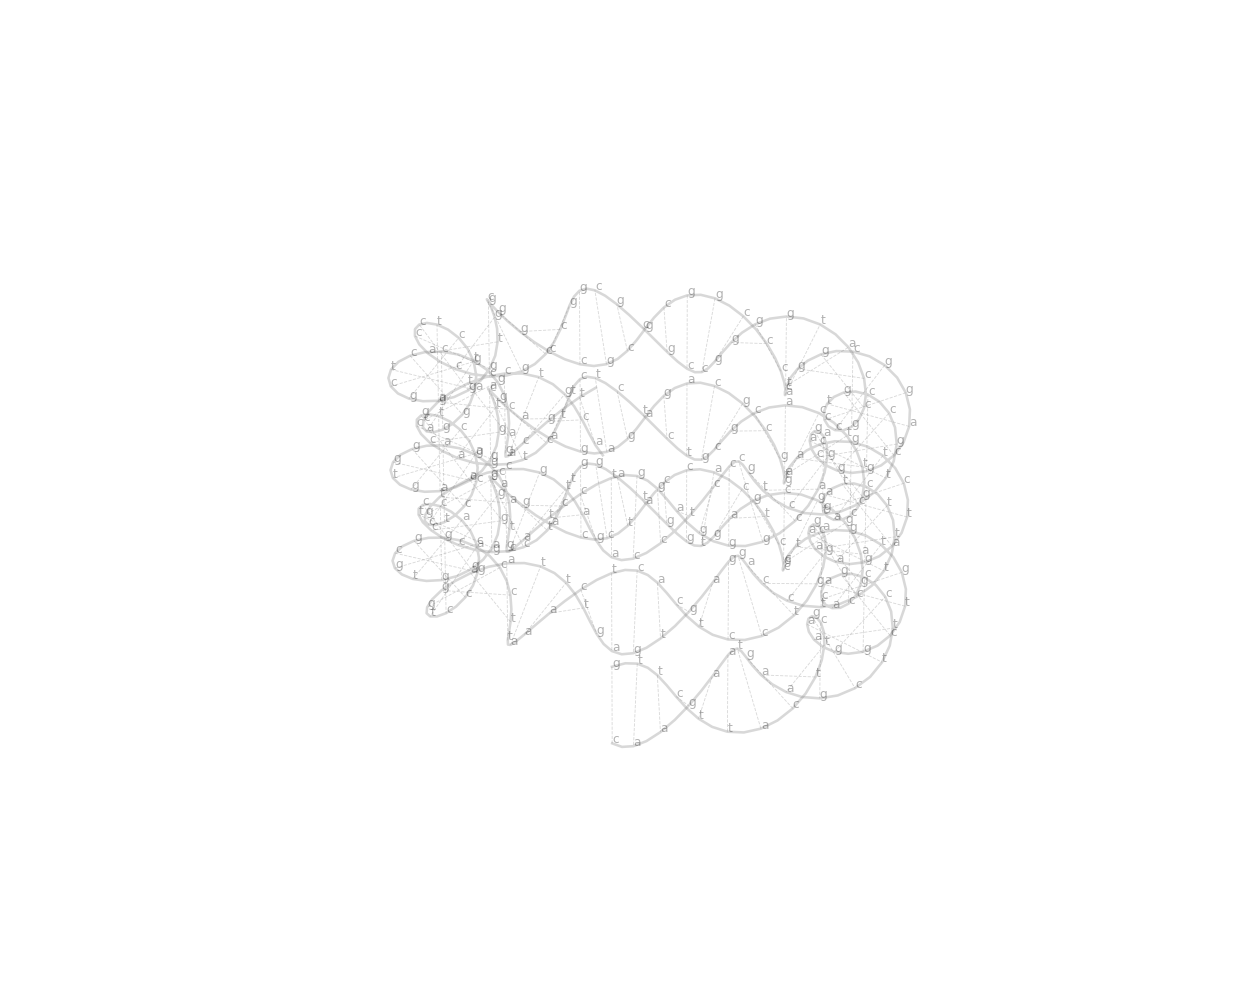

In [13]:
fig = plt.figure(1, figsize=(2 * r2, 2 * r1 * (nlcoils + 1)))
ax = plt.axes(projection = '3d')
ax.set_xlim(-r2 * 1.1, r2 * 1.1)
ax.set_ylim(-r2 * 1.1, r2 * 1.1)
ax.set_zlim(-1, a3[-1:] * 1.1)
ax.set_axis_off()
ax.set_proj_type("persp")
ax.view_init(20, 10)
k = ax.plot3D(coor[:, 0], coor[:, 1], coor[:, 2], color='grey', alpha=0.3)
k2 = ax.plot3D(coor2[:, 0], coor2[:, 1], coor2[:, 2], color='grey', alpha=0.3)

for i in range(ltr_coor.shape[0]):
    ax.text(ltr_coor[i][0], ltr_coor[i][1], ltr_coor[i][2], txt[i], alpha = 0.3, size = 7)
    ax.text(ltr_coor2[i][0], ltr_coor2[i][1], ltr_coor2[i][2], txt2[i], alpha = 0.3, size = 7)
    ax.plot3D((ltr_coor[i,0], ltr_coor2[i, 0]), (ltr_coor[i, 1], ltr_coor2[i, 1]), (ltr_coor[i, 2], ltr_coor2[i, 2]), \
              color = 'grey', alpha = 0.3, linestyle = "--", linewidth = 0.5)
plt.savefig("dhelix.png", transparent = False)

<IPython.core.display.Javascript object>


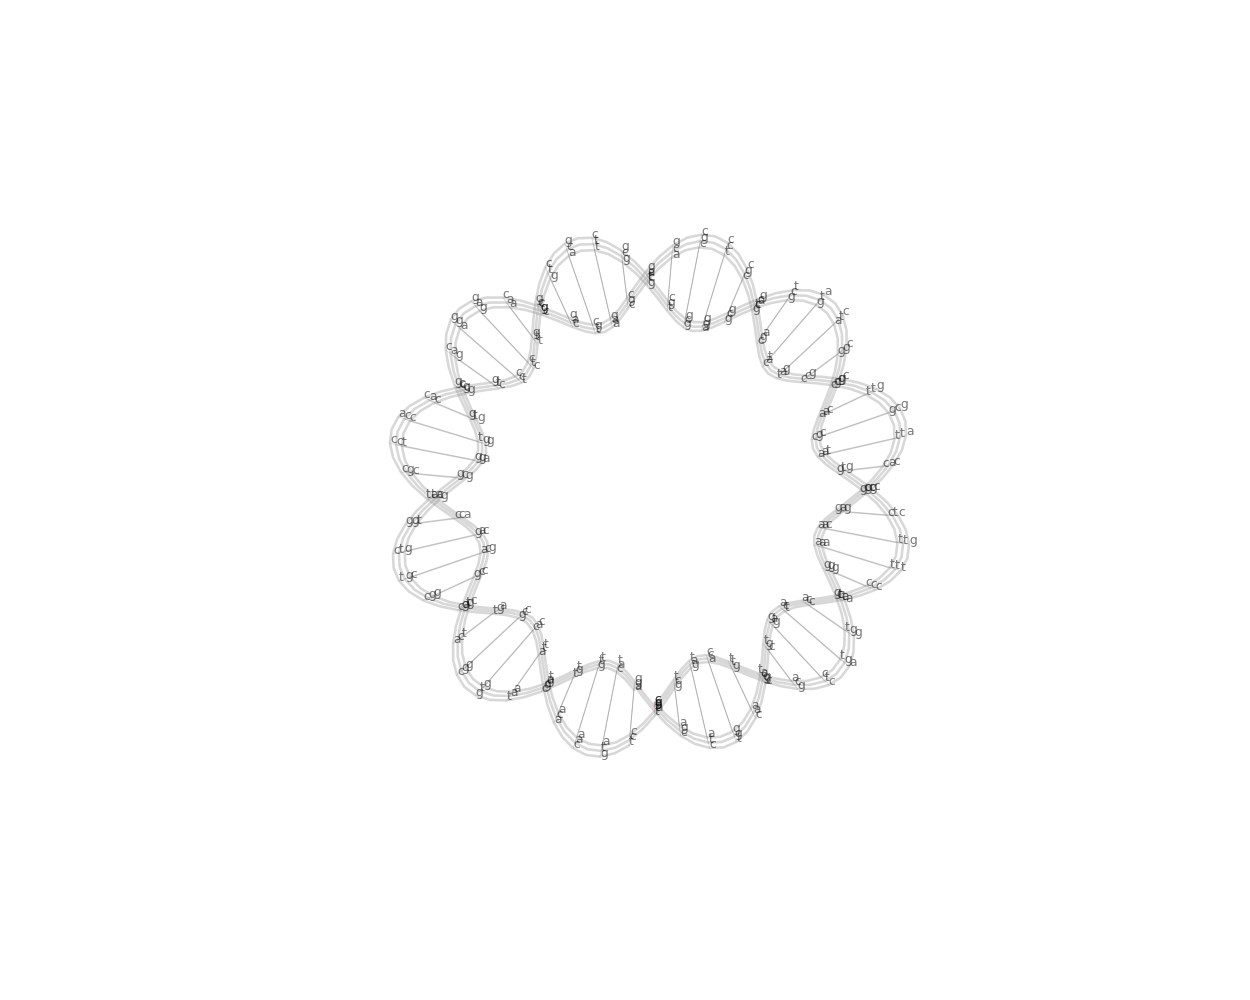

In [14]:
fig2 = plt.figure(2, figsize=(2 * r2, 2 * r1 * (nlcoils+1)))
ax2 = fig2.add_subplot(111, projection = '3d')
ax2.set_xlim(-r2 * 1.1, r2 * 1.1)
ax2.set_ylim(-r2 * 1.1, r2 * 1.1)
ax2.set_zlim(-1, a3[-1:] * 1.1)
ax2.set_proj_type("persp")
ax2.set_axis_off()
ax2.view_init(0, 0)
k=ax2.plot3D(zero_arr[:, 0], zero_arr[:, 1], zero_arr[:, 2], color = 'grey', alpha = 0.3)
k2=ax2.plot3D(zero_arr[:, 0], zero_arr[:, 1], zero_arr[:, 2], color = 'grey', alpha = 0.3)
gg=ax2.plot3D((ltr_coor[0, 0], ltr_coor2[0, 0]) , (ltr_coor[0, 1], ltr_coor2[0, 1]), (ltr_coor[0, 2], ltr_coor2[0, 2]),\
              color = 'red', alpha = 0.3, linestyle = "-", linewidth = 0.5)
tc = [] #text coordinates
cs = [] #collection of sticks

for i in range(ltr_coor.shape[0]):
    cs.append(ax2.plot3D((ltr_coor[0, 0], ltr_coor2[0, 0]) , (ltr_coor[0, 1], ltr_coor2[0, 1]), (ltr_coor[0, 2],\
    ltr_coor2[0, 2]), color = 'grey', alpha = 0.3, linestyle = "-", linewidth = 0.5))

def animate(frame, k, k2, coor, coor2, tc, cs, blit = True):
    ax2.view_init(90 * frame/npts, 360 * frame/npts)
    k[0].set_data_3d(coor[:frame, 0], coor[:frame, 1], coor[:frame, 2])
    k2[0].set_data_3d(coor2[:frame, 0], coor2[:frame, 1], coor2[:frame, 2])
    zz= [k, k2]
    if(frame%ltr_pos == 0):
        i=int(frame / ltr_pos)
        t1=ax2.text(ltr_coor[i][0], ltr_coor[i][1], ltr_coor[i][2], txt[i], alpha = 0.3, size = 7)
        t2=ax2.text(ltr_coor2[i][0], ltr_coor2[i][1], ltr_coor2[i][2], txt2[i], alpha = 0.3, size = 7)
        tc.append(t1)
        tc.append(t2)
        cs[i][0].set_data_3d((ltr_coor[i][0], ltr_coor2[i][0]),  (ltr_coor[i][1], ltr_coor2[i][1]), (ltr_coor[i][2], ltr_coor2[i][2])) 
    zz=zz+tc+cs
    return zz
    

anim = animation.FuncAnimation(fig2, animate, frames=npts, interval = 50, repeat = False, fargs = (k, k2, coor, coor2, tc, cs))
# HTML(anim.to_html5_video())
anim.save('dhelix.gif', writer='imagemagick')
